In [29]:
import numpy as np
import pandas as pd
from __future__ import division
import matplotlib.pyplot as plt
import urllib2,base64
import cPickle as pickle
from collections import Counter
import scipy as sp
import os
import os.path
import cv2
import re
from sklearn import neighbors, datasets,linear_model,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import scale
from sklearn.feature_extraction import image
from sklearn.cluster import MiniBatchKMeans
from sklearn import decomposition
from sklearn import svm
from sklearn.model_selection import cross_val_score
from time import time
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
from scipy.interpolate import interpn
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import griddata
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.cross_validation import KFold, StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs


from operator import itemgetter
%matplotlib inline

### Preprocessing (Extraction etc.)

In [30]:
imgs_dir = os.getcwd()+'\\centered'
pattern = re.compile(".leftlight.pgm")
images_list=list()
for filename in os.listdir(imgs_dir):
    if ".leftlight.pgm" in filename or ".rightlight.pgm" in filename or ".glasses.pgm" in filename:
        continue
    image=cv2.imread(imgs_dir+'\\'+filename,0)
    h,w = image.shape
    dimensions=h*w
    image_flatten = image.flatten()
    images_list.append(image_flatten)

images_list=np.array(images_list)

print "Dataset consists of %d faces, each dimension %d" % (len(images_list) , len(images_list[0]))

#images_list_mean=np.mean(images_list, axis=0)
#images_list_std=np.std(images_list, axis=0)
#np.seterr(divide='ignore', invalid='ignore')
#images_list_sta=(images_list-images_list_mean)/images_list_std
#print images_list_sta

Dataset consists of 120 faces, each dimension 45045


In [31]:
n_components=100
estimators = [
    ('PCA',
     decomposition.PCA(n_components=n_components, svd_solver='auto',
                       whiten=True),
     True),

    ('ICA',
     decomposition.FastICA(n_components=n_components, whiten=True),
     True),
]

pcas_dict=dict()
icas_dict=dict()
for name, estimator, center in estimators:
    print("\n\nExtracting the top %d %s..." % (n_components, name))
    t0 = time()
    data = images_list
    estimator.fit(data)
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    if hasattr(estimator, 'cluster_centers_'):
        components_ = estimator.cluster_centers_
    else:
        components_ = estimator.components_
        
        print 'First {0} principle components given by {1} : {2}'.format(n_components,name, components_)
        if name=='PCA':
            pcas_dict[name]=components_
            variance_explained_ = estimator.explained_variance_ratio_
            pca_transform= estimator.transform(data)
            pcas_dict['variance explained']=variance_explained_
            pcas_dict['transform']=pca_transform
            pcas_dict['estimator']=estimator
            print 'Variance Explained by{0} principle components given by {1} : {2}%'.format(n_components,name, sum(variance_explained_)*100)
        
        else:
            icas_dict[name]=components_
            ica_transform= estimator.transform(data)
            icas_dict['transform']=ica_transform
    



Extracting the top 100 PCA...
done in 0.971s
First 100 principle components given by PCA : [[-0.00051567 -0.00052531 -0.00048011 ..., -0.00437604 -0.0044736
  -0.00415373]
 [ 0.00051949  0.00050999  0.00055161 ..., -0.001      -0.00145184
  -0.00166991]
 [ 0.00018442  0.00019244  0.00015598 ..., -0.00264947 -0.0024346
  -0.0020243 ]
 ..., 
 [ 0.00559676  0.00554676  0.0057168  ..., -0.00537915 -0.00145204
  -0.00026374]
 [-0.0002821  -0.00043505  0.00030122 ..., -0.01055648 -0.0014227
   0.00560515]
 [ 0.0156689   0.01572825  0.01547473 ..., -0.00319113 -0.00192132
  -0.00208375]]
Variance Explained by100 principle components given by PCA : 99.5786597547%


Extracting the top 100 ICA...
done in 1.120s
First 100 principle components given by ICA : [[ -8.44876638e-07  -8.42917899e-07  -8.54324093e-07 ...,   4.72328082e-07
    3.33613520e-07  -2.28845486e-08]
 [ -7.20518955e-07  -7.06289250e-07  -7.67347373e-07 ...,  -1.20946131e-07
   -3.00443554e-07  -4.70069589e-07]
 [ -2.21041152e-0

In [32]:
image_pcas_df = pd.DataFrame(pca_transform)
image_pcas_df.to_csv('img_pcas.csv', sep=',')
image_pcas_df.head(10)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000311,1.260478,0.493643,-0.588369,1.692669,0.263092,-0.426103,-0.646894,0.421300,-1.325852,...,-0.337118,0.258876,0.379773,-0.012702,0.148455,-0.014250,-0.487790,0.168093,-0.184869,0.575959
1,0.125564,-0.074151,0.455647,-0.350872,2.817413,0.571867,0.303277,-0.448025,-0.445277,0.608332,...,-1.166273,1.319511,-0.882402,-0.896367,-0.957348,1.579222,1.975843,-1.505779,1.337256,1.710731
2,0.261691,-0.268405,0.311305,0.023559,3.087438,0.695780,0.927445,-0.108928,-0.920838,0.716292,...,0.853964,0.555309,-1.680198,-0.346931,-1.793077,-1.226327,-1.565518,1.544878,-0.647592,-0.931438
3,0.610912,-0.255309,0.316534,-0.206459,3.136406,0.067486,0.455793,-0.001954,-0.030964,0.787788,...,0.170249,-2.593864,1.214674,-1.680056,2.347386,1.002770,1.575093,-1.594465,0.737833,1.749382
4,0.236464,-0.255635,0.184604,-0.254509,2.821835,1.013878,0.907937,0.361583,-0.499372,0.607670,...,0.080199,0.169488,1.436493,0.481759,0.315495,-0.439555,0.870894,-1.301575,-0.111838,0.145198
5,0.100581,0.055361,0.575342,-0.466115,2.980292,0.083095,0.531270,-0.504509,-0.142549,0.571562,...,-0.025982,-2.621943,0.357392,1.780035,1.148862,-0.846540,-1.110690,2.108681,-0.780012,-0.931901
6,0.514073,-0.453428,0.344987,0.001082,2.820613,0.267482,0.067073,-0.171677,-0.174893,0.429327,...,0.849617,1.923800,-0.541941,0.873983,-0.973584,-0.306711,-1.576388,1.225152,-0.407268,-1.628033
7,0.194989,0.234036,0.984984,0.072157,2.420781,-1.130046,-0.034503,-1.059582,0.340281,-0.041427,...,-0.393485,1.290659,0.168794,0.238902,-1.201883,-0.260707,0.166280,-0.722341,-0.292900,-0.368508
8,-1.467118,0.269504,1.282381,-0.490023,1.513731,1.735230,0.578780,0.164935,-1.062330,1.560563,...,0.100139,0.294333,-0.241614,-0.499922,0.383598,0.159705,0.208191,-0.154083,0.285302,-0.492140
9,-0.476560,0.319526,0.687706,-0.451937,-0.588633,-0.512861,-0.446273,-1.244887,-0.945385,2.632145,...,-1.029015,0.191051,0.214895,-3.341172,-0.318604,1.344341,-0.610297,-1.912399,0.885819,-2.103778


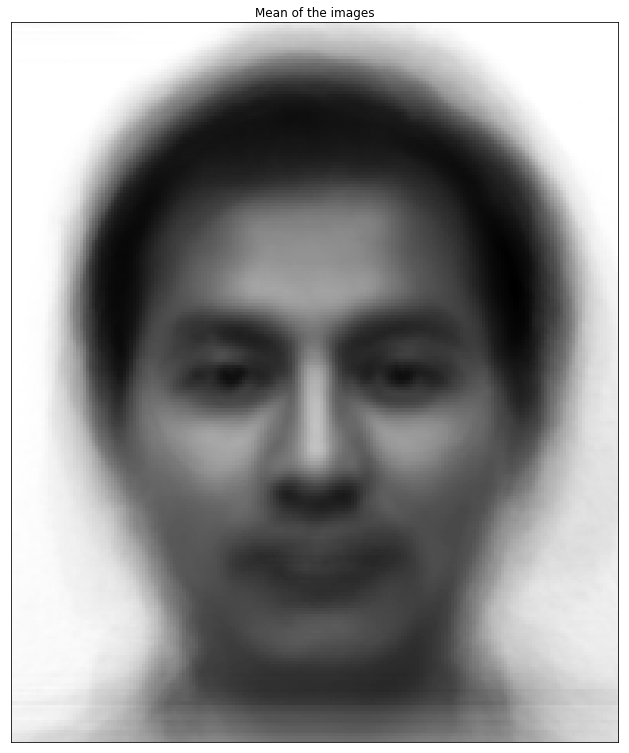

In [33]:
#TEST!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

#### Get the mean image of PCA analysis
img_score = image_pcas_df.iloc[[1]].values.tolist()[0]
mean_ori_image = np.mean(images_list,axis=0)

#if we only use 19
img_score_19=img_score[19]
img_prime_score =np.zeros(len(img_score))
img_prime_score[19]=img_score_19

fig_mean = plt.figure(1) 
fig_mean.set_size_inches(10, 10, forward=True)
fig_mean.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 

ax_mean_ori = fig_mean.add_subplot(1,1,1, xticks=[], yticks=[]) 
ax_mean_ori.imshow(np.reshape(mean_ori_image, (h,w)), cmap=plt.cm.gray, interpolation='nearest') 
ax_mean_ori.set_title('Mean of the images')
#print mean_score

First 40 Reconstruct usign first 100 PCs images 



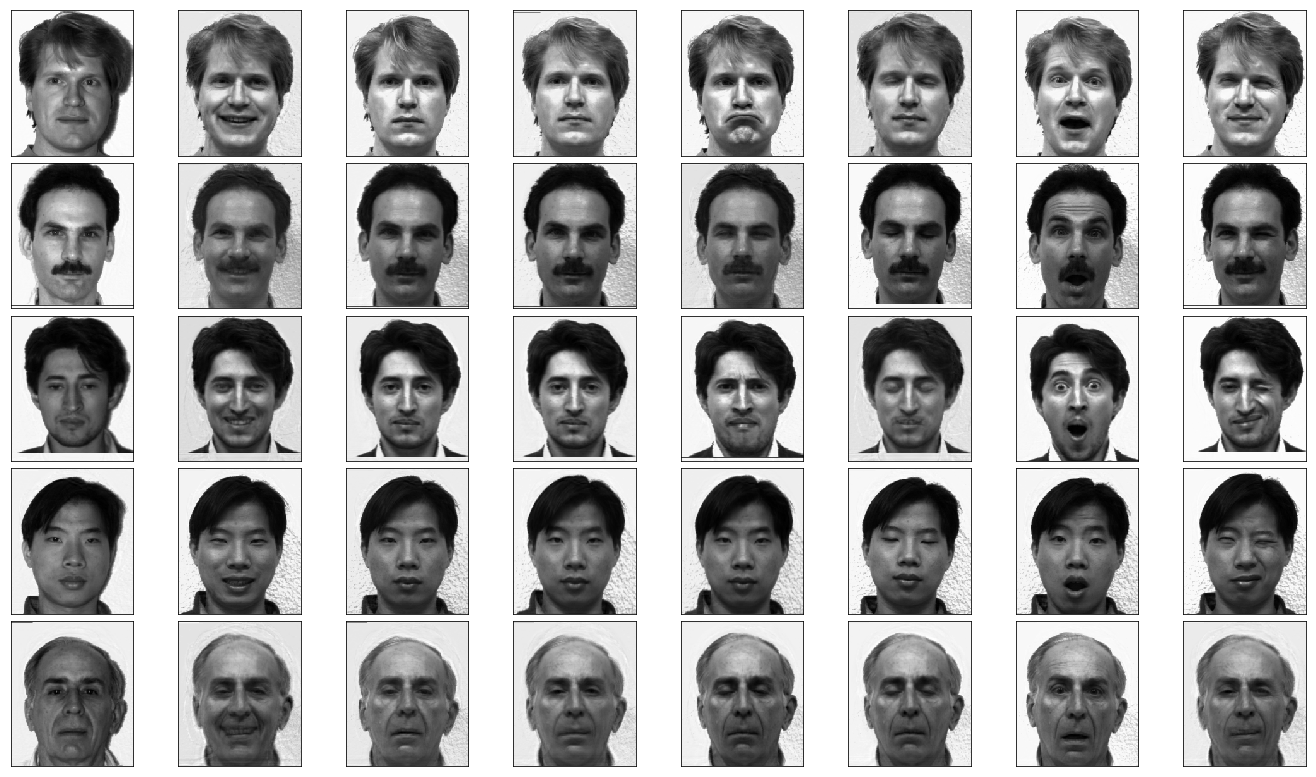

In [34]:
fig_pca = plt.figure(2) 
fig_pca.set_size_inches(18.5, 10.5, forward=True)
fig_pca.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 
# plot the faces, each image is 64 by 64 pixels 

print "First 40 Reconstruct usign first 100 PCs images \n"
col=8
row=5
for i in range(40): 
    ax_pca = fig_pca.add_subplot(row, col, i+1, xticks=[], yticks=[]) 
    ax_pca.imshow(np.reshape(pcas_dict['estimator'].inverse_transform(pcas_dict['transform'][i]), (h,w)), cmap=plt.cm.gray, interpolation='nearest') 


First 40 Orginal images  



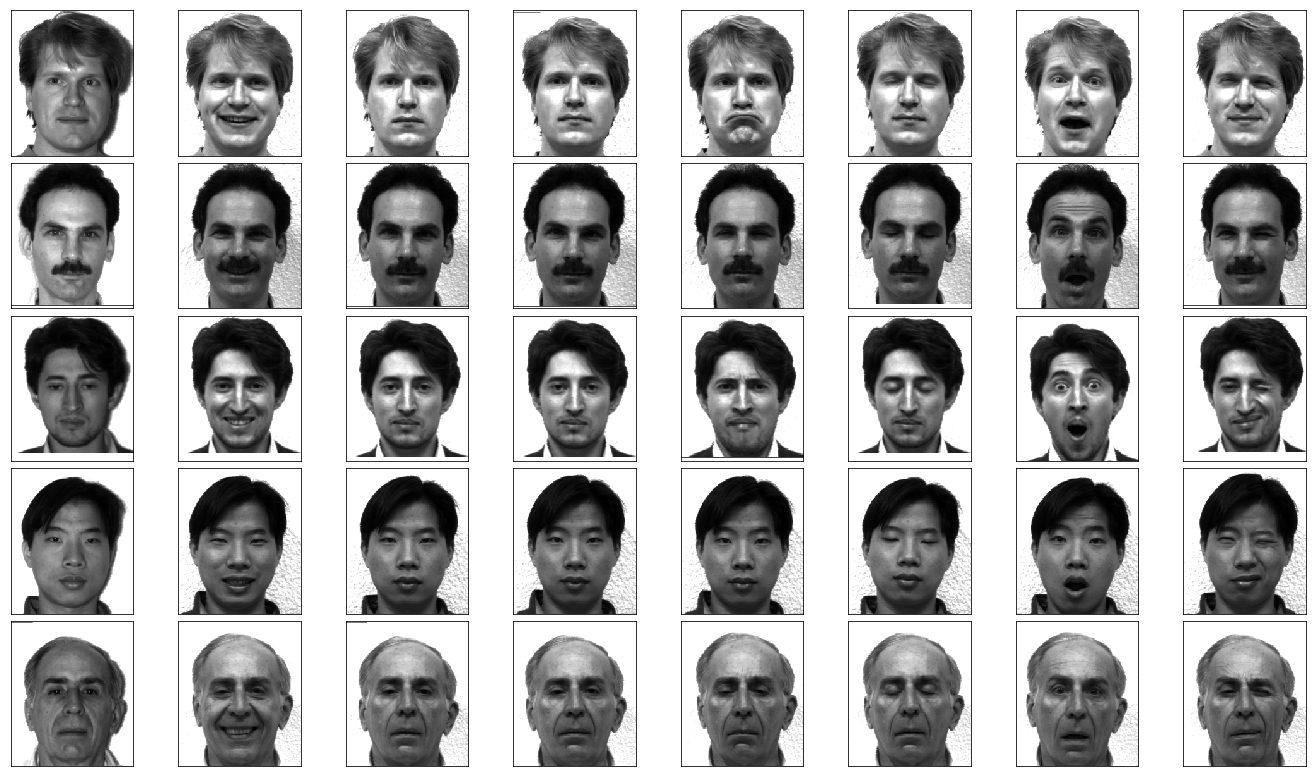

In [35]:
fig_pca = plt.figure(2) 
fig_pca.set_size_inches(18.5, 10.5, forward=True)
fig_pca.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 
# plot the faces, each image is 64 by 64 pixels 

print "First 40 Orginal images  \n"
col=8
row=5
for i in range(40): 
    ax_pca = fig_pca.add_subplot(row, col, i+1, xticks=[], yticks=[]) 
    ax_pca.imshow(np.reshape(images_list[i], (h,w)), cmap=plt.cm.gray, interpolation='nearest') 


### Feature Selection and Linear Regression Modelling - PCAs

In [36]:
mat_vector=loadmat('emotion-strength.mat')
images_score=np.concatenate( mat_vector['emotion_strength'], axis=0 )
image_pcas_df['score']=images_score
image_pcas_df['score']=np.array(image_pcas_df['score'].tolist()) - np.mean(image_pcas_df['score'].tolist()) 

holdout_per=0.2
image_pcas_test_df = image_pcas_df.sample(frac=holdout_per)
image_pcas_training_df = image_pcas_df.iloc[list(set(image_pcas_df.index.values.tolist())-set(image_pcas_test_df.index.values.tolist()))]

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.9s finished

[2017-11-24 23:37:50] Features: 1/50 -- score: -0.375349403591[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  99 out of  99 | elapsed:    0.9s finished

[2017-11-24 23:37:51] Features: 2/50 -- score: -0.352850407949[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  98 out of  98 | elapsed:    0.9s finished

[2017-11-24 23:37:52] Features: 3/50 -- score: -0.331016518605[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  97 out of  97 | elapsed:    0.9s finished

[2017-11-24 23:37:53] Features: 4/50 -- score: -0.312279734196[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:    1.9s finishe

[Parallel(n_jobs=1)]: Done  62 out of  62 | elapsed:    0.9s finished

[2017-11-24 23:38:36] Features: 39/50 -- score: -0.0802913537946[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  61 out of  61 | elapsed:    0.9s finished

[2017-11-24 23:38:37] Features: 40/50 -- score: -0.0791709475664[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    0.9s finished

[2017-11-24 23:38:38] Features: 41/50 -- score: -0.0781768282823[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  59 out of  59 | elapsed:    0.9s finished

[2017-11-24 23:38:39] Features: 42/50 -- score: -0.0766356049288[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  58 out of  58 | elapsed:    0.8s finished

[2017-11-24 23:38:40] Features: 43/50 -- score: -0.0762856270589[Para

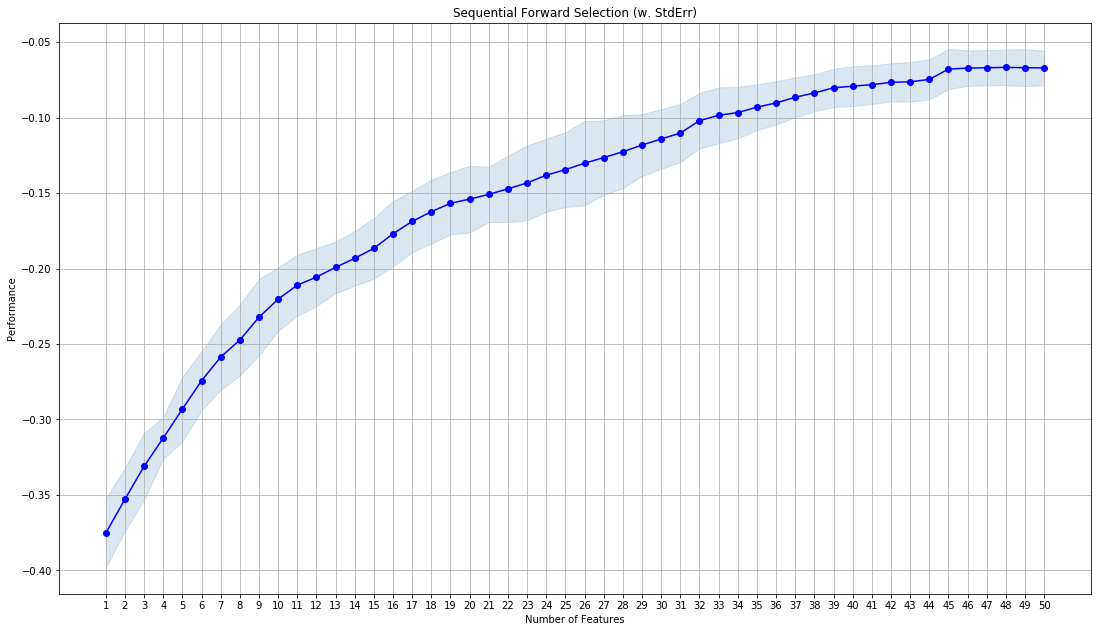

In [37]:
lr = linear_model.LinearRegression()
sfs_greedy = SFS(lr, 
           k_features=50, 
           forward=True, 
           floating=False, 
           verbose=2,
           scoring='neg_mean_squared_error',
           cv=10)

sfs_greedy = sfs_greedy.fit(image_pcas_training_df.iloc[:, :-1].as_matrix(), image_pcas_training_df['score'].tolist())
fig = plot_sfs(sfs_greedy.get_metric_dict(), kind='std_err')
fig.set_size_inches(18.5, 10.5, forward=True)
plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

In [38]:
df_features_forward_greedy = pd.DataFrame.from_dict(sfs_greedy.get_metric_dict()).T
df_features_forward_greedy

,avg_score,ci_bound,cv_scores,feature_idx,std_dev,std_err
1,-0.375349,0.0511226,"[-0.384962396513, -0.373334516108, -0.43236162...","(19,)",0.0688323,0.0229441
2,-0.35285,0.0465728,"[-0.301439603184, -0.349301617039, -0.35432051...","(42, 19)",0.0627064,0.0209021
3,-0.331017,0.0491123,"[-0.292197446813, -0.338276338074, -0.34341550...","(42, 19, 29)",0.0661256,0.0220419
4,-0.31228,0.0307439,"[-0.289935956599, -0.293212183455, -0.35634438...","(42, 19, 29, 55)",0.041394,0.013798
5,-0.293104,0.0476524,"[-0.261429318235, -0.271957611257, -0.38741411...","(34, 42, 19, 29, 55)",0.0641599,0.0213866
6,-0.274346,0.0435388,"[-0.228937167229, -0.258257008521, -0.31749289...","(34, 19, 55, 42, 29, 30)",0.0586213,0.0195404
7,-0.258621,0.0484291,"[-0.224400134424, -0.250406274012, -0.37669212...","(34, 19, 55, 25, 42, 29, 30)",0.0652056,0.0217352
8,-0.247395,0.0522136,"[-0.197477216504, -0.277099113904, -0.30991205...","(34, 19, 20, 55, 25, 42, 29, 30)",0.0703012,0.0234337
9,-0.232231,0.0564467,"[-0.149366893775, -0.298913929344, -0.27607772...","(34, 42, 47, 19, 20, 55, 25, 29, 30)",0.0760007,0.0253336
10,-0.220277,0.0469486,"[-0.175218583744, -0.293308262466, -0.24707192...","(34, 37, 42, 47, 19, 20, 55, 25, 29, 30)",0.0632124,0.0210708


In [39]:
print('Best features:', sfs_greedy.k_feature_idx_)

('Best features:', (0, 3, 4, 6, 8, 9, 10, 11, 13, 15, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 34, 35, 37, 38, 42, 43, 47, 49, 51, 52, 53, 55, 57, 58, 59, 62, 66, 67, 70, 71, 72, 73, 75, 78, 79, 80, 86, 94, 96, 99))


In [40]:
##forward selection by definition from the book
greedy_selected_columns_index=list()

#selected_column_indice=df_features_forward_greedy['feature_idx'].as_matrix()[df_features_forward_greedy['avg_score'].idxmax()-1]
greedy_selected_columns_index=np.array(df_features_forward_greedy[df_features_forward_greedy['avg_score']==max(df_features_forward_greedy['avg_score'].tolist())]['feature_idx'].values[0])
greedy_colname_list = image_pcas_training_df.columns[greedy_selected_columns_index].tolist()
print "Selected columns by simple greedy sequential forward selection are: \n",greedy_colname_list, " with size ", len(greedy_colname_list)

Selected columns by simple greedy sequential forward selection are: 
[0L, 3L, 4L, 8L, 9L, 10L, 11L, 13L, 15L, 19L, 20L, 21L, 22L, 23L, 24L, 25L, 26L, 29L, 30L, 34L, 35L, 37L, 38L, 42L, 43L, 47L, 49L, 51L, 52L, 53L, 55L, 57L, 58L, 59L, 62L, 66L, 67L, 71L, 72L, 73L, 75L, 78L, 79L, 80L, 86L, 94L, 96L, 99L]  with size  48


In [41]:
greedy_selected_colname_list = greedy_colname_list + ["score"]

#### Note! , try to rank performance of all features in linear modeling the faces 

In [42]:
score_list=list()
for column in image_pcas_training_df.iloc[:, :-1].columns.tolist():
    lr_greedy = linear_model.LinearRegression()
    scores = cross_val_score(lr_greedy, np.array([image_pcas_training_df[column].tolist()]).T, image_pcas_training_df['score'].tolist(), cv=10, scoring='neg_mean_squared_error')
    #print "Score with 10 fold cross validation on column ", column, " for training set ", scores.mean()
    score_list.append((column,scores.mean()))

score_sorted_list=sorted(score_list,key=itemgetter(1), reverse=True)
print "Sorted PCA performance list of single feature", score_sorted_list

Sorted PCA performance list of single feature [(19L, -0.375349403591339), (55L, -0.41662200411225936), (29L, -0.4216119385127598), (42L, -0.42190243279964823), (34L, -0.42203456255312732), (30L, -0.42406445519999236), (13L, -0.42415748831960071), (20L, -0.42965121655375105), (47L, -0.43674437027673252), (37L, -0.43732572264174846), (26L, -0.43781555485090917), (52L, -0.43800973559239065), (25L, -0.43807770979088689), (9L, -0.43853332180402543), (70L, -0.43977540635783929), (16L, -0.43980756080906974), (31L, -0.44054423376894974), (23L, -0.44128594789496278), (5L, -0.44227745303596244), (51L, -0.44261548024413988), (53L, -0.44282442874536337), (22L, -0.44302074748544851), (82L, -0.44355777042424577), (15L, -0.44387097584520446), (45L, -0.44399202929966214), (27L, -0.44442307199298281), (8L, -0.44488752294988643), (21L, -0.44489571030817726), (3L, -0.44519957473591321), (14L, -0.44525775802306472), (35L, -0.44534892483505956), (24L, -0.44535026634467856), (57L, -0.44539376345260723), (49

### Cross-validated the selected best fit subset columns with the 20% testing set - PCAs

In [43]:
image_pcas_selected_training_df=image_pcas_training_df[greedy_selected_colname_list]
image_pcas_selected_test_df=image_pcas_test_df[greedy_selected_colname_list]

lr_greedy = linear_model.LinearRegression()
scores = cross_val_score(lr_greedy, image_pcas_selected_training_df.iloc[:, :-1].as_matrix(), image_pcas_selected_training_df['score'].tolist(), cv=10, scoring='neg_mean_squared_error')
print "Score with 10 fold cross validation for training set ", scores.mean()

lr_greedy.fit(image_pcas_selected_training_df.iloc[:, :-1].as_matrix(), image_pcas_selected_training_df['score'].tolist())
image_pred = lr_greedy.predict(image_pcas_selected_test_df.iloc[:, :-1].as_matrix())

print "Outter Prediction Mean squared error is ", mean_squared_error(image_pcas_test_df['score'].tolist(), image_pred)

Score with 10 fold cross validation for training set  -0.066727417938
Outter Prediction Mean squared error is  0.53746209844


#### Fit the subset columns with entire dataset and try to see the linear coefficient 

In [44]:
image_pcas_selected_df=image_pcas_df[greedy_selected_colname_list]

lr_greedy = linear_model.LinearRegression()
scores = cross_val_score(lr_greedy, image_pcas_selected_training_df.iloc[:, :-1].as_matrix(), image_pcas_selected_training_df['score'].tolist(), cv=10, scoring='neg_mean_squared_error')
print "Score with 10 fold cross validation for training set ", scores.mean()

lr_greedy.fit(image_pcas_selected_training_df.iloc[:, :-1].as_matrix(), image_pcas_selected_training_df['score'].tolist())
image_pred = lr_greedy.predict(image_pcas_selected_df.iloc[:, :-1].as_matrix())

print "Outter Prediction Mean squared error is ", mean_squared_error(image_pcas_selected_df['score'].tolist(), image_pred)

linear_coeffs=lr_greedy.coef_
print "Coefficients for this fit ", linear_coeffs


Score with 10 fold cross validation for training set  -0.066727417938
Outter Prediction Mean squared error is  0.129394218403
Coefficients for this fit  [-0.0304757  -0.08790099 -0.05595814  0.0422637   0.06094573  0.09571999
 -0.13509133 -0.13369923  0.04872117  0.24527399  0.15368374  0.03893264
  0.06315974  0.08817987 -0.02756581  0.12869245 -0.08872511  0.11211146
  0.12571502 -0.16418044 -0.07363714 -0.07392051 -0.02311312  0.07973705
  0.0293956   0.08343436 -0.05958406  0.07830687  0.09036488  0.12420754
  0.19123617 -0.07010561 -0.08795793 -0.06011375  0.0462446  -0.13660245
 -0.03070751 -0.01233109 -0.03336534 -0.08485142  0.03417391 -0.05797599
  0.09249668  0.0611555  -0.07688431 -0.03629125  0.06980086 -0.05444961]


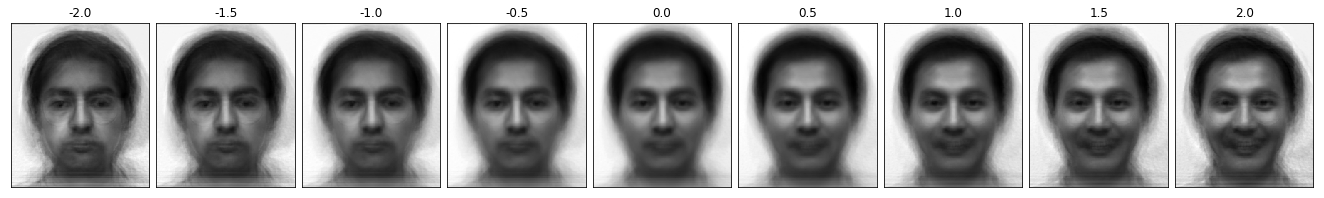

In [85]:

#image_pcas_selected_df['PRED']=image_pred

fig_interp_subset_pca = plt.figure() 
fig_interp_subset_pca.set_size_inches(200, 200, forward=True)
fig_interp_subset_pca.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 

strength_array=np.arange(-2 , 2.5, 0.5)



row= 1
col= len(strength_array)
i=0
for strength in strength_array:
    scale = strength/np.dot(linear_coeffs,linear_coeffs)
    weights = np.array(linear_coeffs)*scale
    img_empty_score =np.zeros(100)
    j=0
    for col in greedy_selected_columns_index:
        img_empty_score[col]=weights[j]
        j=j+1
    ax_interp_pca = fig_interp_subset_pca.add_subplot(row, col, i+1, xticks=[], yticks=[]) 
    ax_interp_pca.imshow(np.reshape(pcas_dict['estimator'].inverse_transform(img_empty_score), (h,w)), cmap=plt.cm.gray, interpolation='nearest')
    ax_interp_pca.set_title(strength)
    i=i+1

By using the subset of pcs which has verified for the best linear fitting, the appearance of the face has multiple features changed at same time. Generally, the cheekbones, jaw, mouth corners rise. 
Nasolabial folds (what is it https://en.wikipedia.org/wiki/Nasolabial_fold) gets deeper.

#### Fit the best column 19th with entire dataset and try to see the linear coefficient 
> - By sequential forward feature selection, PC19 has been identified as the best exclusive feature for linear regression modelling with emotion strength
> - The linear model in this section will show a scale of emotion strength and the synthetic corresponding faces 

In [46]:
image_pcas_19_df=image_pcas_df[19]

lr_greedy_19 = linear_model.LinearRegression()
scores = cross_val_score(lr_greedy_19, np.array(image_pcas_selected_training_df[19].tolist()).reshape(-1, 1), np.array(image_pcas_selected_training_df['score'].tolist()).reshape(-1, 1), cv=10, scoring='neg_mean_squared_error')
print "Score with 10 fold cross validation for training set ", scores.mean()

lr_greedy_19.fit(np.array(image_pcas_selected_training_df[19].tolist()).reshape(-1, 1), np.array(image_pcas_selected_training_df['score'].tolist()).reshape(-1, 1))
image_pred = lr_greedy_19.predict(np.array(image_pcas_selected_df[19].tolist()).reshape(-1, 1))

print "Outter Prediction Mean squared error is ", mean_squared_error(image_pcas_selected_df['score'].tolist(), image_pred)

linear_coeffs_19=lr_greedy_19.coef_[0]
print "Coefficients for this linear fit ", linear_coeffs_19



Score with 10 fold cross validation for training set  -0.375349403591
Outter Prediction Mean squared error is  0.367778131477
Coefficients for this linear fit  [ 0.25717993]


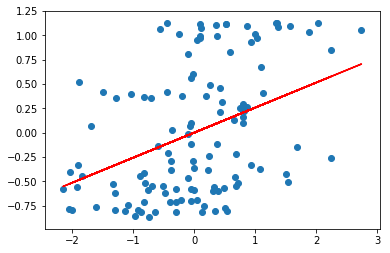

In [96]:
fig, ax = plt.subplots()

ax.plot(np.array(image_pcas_selected_df[19].tolist()), np.array(image_pcas_selected_df[19].tolist())*linear_coeffs_19, color='red')
ax.scatter(np.array(image_pcas_selected_df[19].tolist()), image_pcas_selected_df['score'].tolist())

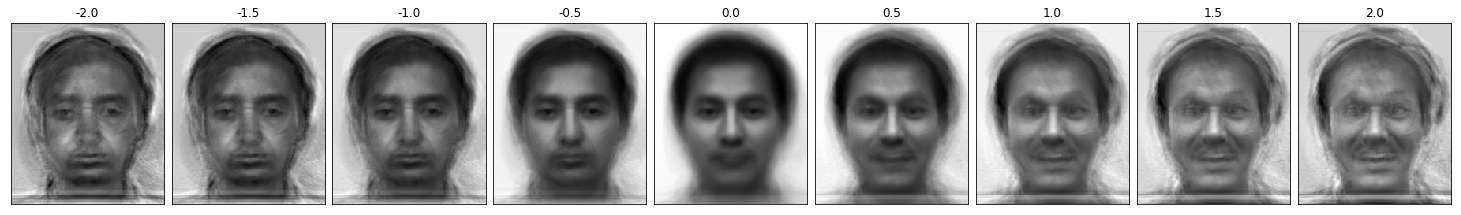

In [86]:
image_pcas_19_df['PRED']=image_pred

fig_interp_19_pca = plt.figure() 
fig_interp_19_pca.set_size_inches(20, 20, forward=True)
fig_interp_19_pca.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 

strength_array=np.arange(-2 , 2.5, 0.5)

row= 1
col= len(strength_array)
i=0
for strength in strength_array:
    closest_image = strength/linear_coeffs_19
    img_empty_score =np.zeros(100)
    img_empty_score[19]=closest_image
    ax_interp_19_pca = fig_interp_19_pca.add_subplot(row, col, i+1, xticks=[], yticks=[]) 
    ax_interp_19_pca.imshow(np.reshape(pcas_dict['estimator'].inverse_transform(img_empty_score), (h,w)), cmap=plt.cm.gray, interpolation='nearest')
    ax_interp_19_pca.set_title(strength)
    i=i+1

It can be seen that the mouth shape of the image series has certain variation as emotion = -2, it has a flat, sad face on the left and along the increment of emotion strengh, 
1. the areas on the cheeks closer to mouth has a close correlation with emotion strength. 
2. While the emotion strength rises, the contrast of Nasolabial folds on both side of cheek is also enhanced 

#### Fit the second best column 13th with entire dataset and try to see the linear coefficient
> - By sequential forward feature selection, PC13 has been identified as the second best exclusive feature for linear regression modelling with emotion strength
> - The linear model in this section will show a scale of emotion strength and the synthetic corresponding faces 

In [48]:
image_pcas_13_df=image_pcas_df[13]

lr_greedy_13 = linear_model.LinearRegression()
scores = cross_val_score(lr_greedy_13, np.array(image_pcas_selected_training_df[13].tolist()).reshape(-1, 1), np.array(image_pcas_selected_training_df['score'].tolist()).reshape(-1, 1), cv=10, scoring='neg_mean_squared_error')
print "Score with 10 fold cross validation for training set ", scores.mean()

lr_greedy_13.fit(np.array(image_pcas_selected_training_df[13].tolist()).reshape(-1, 1), np.array(image_pcas_selected_training_df['score'].tolist()).reshape(-1, 1))
image_pred = lr_greedy_13.predict(np.array(image_pcas_selected_df[13].tolist()).reshape(-1, 1))

print "Outter Prediction Mean squared error is ", mean_squared_error(image_pcas_selected_df['score'].tolist(), image_pred)

linear_coeffs_13=lr_greedy_13.coef_[0]
print "Coefficients for this linear fit ", linear_coeffs_13



Score with 10 fold cross validation for training set  -0.42415748832
Outter Prediction Mean squared error is  0.420000984447
Coefficients for this linear fit  [-0.1521444]


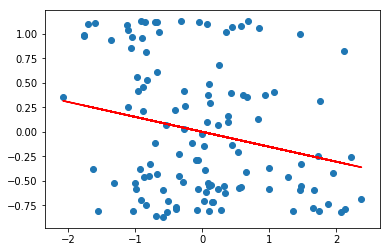

In [97]:
fig, ax = plt.subplots()

ax.plot(np.array(image_pcas_selected_df[13].tolist()), np.array(image_pcas_selected_df[13].tolist())*linear_coeffs_13, color='red')
ax.scatter(np.array(image_pcas_selected_df[13].tolist()), image_pcas_selected_df['score'].tolist())

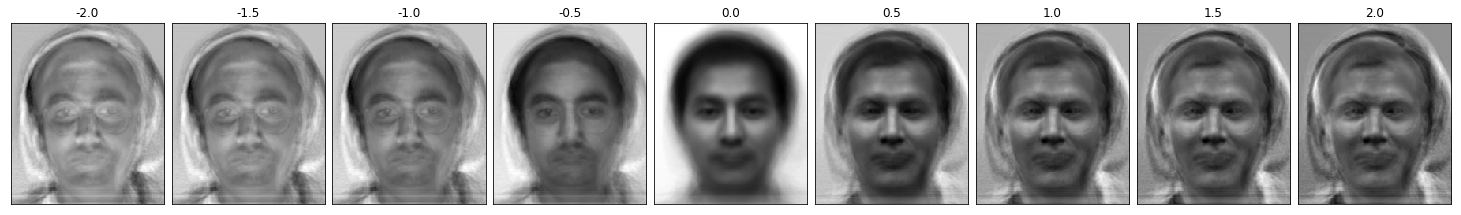

In [87]:
image_pcas_13_df['PRED']=image_pred

fig_interp_13_pca = plt.figure() 
fig_interp_13_pca.set_size_inches(20, 20, forward=True)
fig_interp_13_pca.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 

strength_array=np.arange(-2 , 2.5, 0.5)

row= 1
col= len(strength_array)
i=0
for strength in strength_array:
    closest_image = strength/linear_coeffs_13
    img_empty_score =np.zeros(100)
    img_empty_score[13]=closest_image
    ax_interp_13_pca = fig_interp_13_pca.add_subplot(row, col, i+1, xticks=[], yticks=[]) 
    ax_interp_13_pca.imshow(np.reshape(pcas_dict['estimator'].inverse_transform(img_empty_score), (h,w)), cmap=plt.cm.gray, interpolation='nearest')
    ax_interp_13_pca.set_title(strength)
    i=i+1

It can be seen that the shape of mounth of the images do not change, but the cheekbones of the face series has certain variation. When emotion = -2, the man has a low face cheekbones and along the increment of emotion strengh, the cheekbone is low and ambigious, along the serie to right, the cheekbones are getting higher, more unambigious and more protruding 